## 3-Way Sentiment Analysis of Amazon Customer Reviews
#### Overview
In this project, we'll build a classification system with a 3-way polarity(Positive, Negative, Neutral) to classify the customer 
reviews of Amazon's Grocery and Gourmet Food platform.

we'll first create a structured database from our raw data which is in an unstructured json format, preprocess it using <b>NLTK</b>
and then deploy <b>Naive Bayes classifier</b> to classify the reviews. we'll also compare the performance of our model against <b>Decision trees</b>
and <b>Support Vector Machines</b>.

#### Data
- The dataset has been taken from Amazon Product Data, Julian McAuley UCSD.
- We have taken 5k customer reviews with ratings in the range of 1-5.

In [78]:
#libraries required to import data
import json
from pandas import DataFrame

In [79]:
# Load the Amazon Grocery and Gourmet Food platform customer reviews dataset
data = []
with open('Grocery_and_Gourmet_Food_5.json') as file:
    for i in file:
        if len(data) <= 5000:
            data.append(json.loads(i))

### Data Prep
Converting the unstructured data in the json format into a structured database using pandas dataframe so that it can be 
preprocessed and applied to our machine learning model.

In [116]:
# unstructured json file
data[0:2]

[{'reviewerID': 'A1VEELTKS8NLZB',
  'asin': '616719923X',
  'reviewerName': 'Amazon Customer',
  'helpful': [0, 0],
  'reviewText': 'Just another flavor of Kit Kat but the taste is unique and a bit different.  The only thing that is bothersome is the price.  I thought it was a bit expensive....',
  'overall': 4.0,
  'summary': 'Good Taste',
  'unixReviewTime': 1370044800,
  'reviewTime': '06 1, 2013'},
 {'reviewerID': 'A14R9XMZVJ6INB',
  'asin': '616719923X',
  'reviewerName': 'amf0001',
  'helpful': [0, 1],
  'reviewText': "I bought this on impulse and it comes from Japan,  which amused my family,  all those weird stamps and markings on the package. So that was fun.  It said it would take about a month to arrive and it did take that long.  I was hoping for a more interesting taste but to our family,  it just tasted a bit less flavorful or weaker than the standard milk chocolate kit kat.  The green tea flavor was too subtle for the sugar and it just tasted sweet. The wafers were very c

In [81]:
#creating a structured database from the unstructured json file using pandas dataframe
df = DataFrame(data)
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1VEELTKS8NLZB,616719923X,Amazon Customer,"[0, 0]",Just another flavor of Kit Kat but the taste i...,4.0,Good Taste,1370044800,"06 1, 2013"
1,A14R9XMZVJ6INB,616719923X,amf0001,"[0, 1]",I bought this on impulse and it comes from Jap...,3.0,"3.5 stars, sadly not as wonderful as I had hoped",1400457600,"05 19, 2014"
2,A27IQHDZFQFNGG,616719923X,Caitlin,"[3, 4]",Really good. Great gift for any fan of green t...,4.0,Yum!,1381190400,"10 8, 2013"
3,A31QY5TASILE89,616719923X,DebraDownSth,"[0, 0]","I had never had it before, was curious to see ...",5.0,Unexpected flavor meld,1369008000,"05 20, 2013"
4,A2LWK003FFMCI5,616719923X,Diana X.,"[1, 2]",I've been looking forward to trying these afte...,4.0,"Not a very strong tea flavor, but still yummy ...",1369526400,"05 26, 2013"


In [82]:
# removing non-relevant columns
df.drop(['reviewerID','asin','reviewerName','helpful','summary','unixReviewTime','reviewTime'], axis=1, inplace=True)

In [83]:
# renaming the columns of our dataset
df = df.rename(columns={"reviewText":"Reviews", "overall":"Rating"})

In [84]:
df.head()

,Reviews,Rating
0,Just another flavor of Kit Kat but the taste i...,4.0
1,I bought this on impulse and it comes from Jap...,3.0
2,Really good. Great gift for any fan of green t...,4.0
3,"I had never had it before, was curious to see ...",5.0
4,I've been looking forward to trying these afte...,4.0


In [85]:
#checking for missing values
df.isnull().values.any()

False

## Data Preprocessing
- Using the Regular Expression (re) package, we'll substitute the special characters in our reviews with a space.
- We'll convert all the letters to lower case.
- We'll split sentences to words.
- We'll remove stopwords and convert each word into it's root form.
- Finally, we'll combine all the reviews separated by a space.

In [86]:
# Libraries required for data preprocessing
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [87]:
#Data Transformation
ps = PorterStemmer()
corpus = []
for i in range(0, len(df)):
    review = re.sub('[^a-zA-Z]', ' ', df['Reviews'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [115]:
corpus[0:5]

['anoth flavor kit kat tast uniqu bit differ thing bothersom price thought bit expens',
 'bought impuls come japan amus famili weird stamp mark packag fun said would take month arriv take long hope interest tast famili tast bit less flavor weaker standard milk chocol kit kat green tea flavor subtl sugar tast sweet wafer crispi good tast bit anem us happi bought need buy',
 'realli good great gift fan green tea expens purchas candi across sea',
 'never curiou see like smooth great subtl good flavor order plan make routin',
 'look forward tri hear popular japan among kit kat fan well recommend order warm weather melt becom smushi order mine right summer began bit mushi let solidifi room temp afterward tri tast fine expect stronger green tea matcha flavor actual quit subtl outer coat creami overli sugari like overal say insan good definit yummi treat']

In [89]:
#wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt 

stopwords = set(STOPWORDS)

def show_wordcloud(df, title = None):
    wordcloud = WordCloud(
        background_color='White',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(df))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

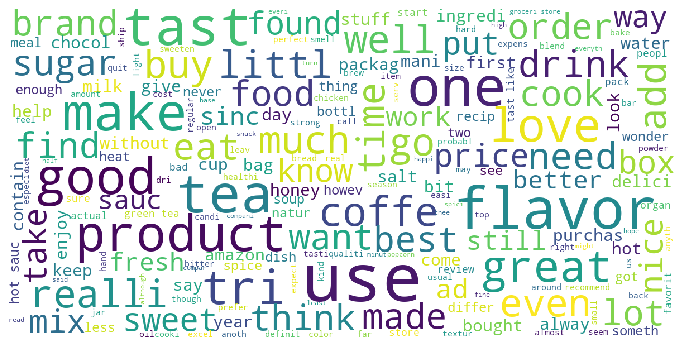

In [90]:
show_wordcloud(corpus)

Now, we'll convert the data into a document matrix where sentences are replaced by a vector which gives the count of each word's 
occurence, this is referred as Bag of words.

In [91]:
#parsing the data into a vector, creating Bag of Words
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(corpus).toarray()
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

Now we'll define the polarity based on the ratings of the reviews
- Positive(4-5) = 1
- Neutral (3)   = 0
- Negative(1-2) = -1

In [92]:
pol = []
for i in df['Rating']:
    if i == 3:
        x = 0 
    elif i > 3:
        x = 1
    else:
        x = -1
    pol.append(x)
    
df['pos_neg'] = pol

In [93]:
y = df['pos_neg']

Splitting the data into a training set and a test set
- Training set will be used the train the Machine Learning Classifiers
- Test set will be used to check the performance of the model on a new dataset

In [94]:
#creating a train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

## Naive Bayes Classifier

In [96]:
#Naive base classifier
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(X_train, y_train)

y_pred=model.predict(X_test)

In [97]:
# Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.8451548451548452

In [98]:
# Classification report and Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.50      0.15      0.23        85
           0       0.30      0.04      0.07        73
           1       0.86      0.98      0.92       843

    accuracy                           0.85      1001
   macro avg       0.55      0.39      0.41      1001
weighted avg       0.79      0.85      0.80      1001

[[ 13   2  70]
 [  5   3  65]
 [  8   5 830]]


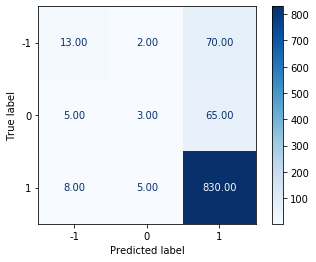

In [103]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test, y_test, cmap = 'Blues', values_format= '.2f')

The Accuracy of Naive Bayes Classifiers is <b>85%</b>

## Decision Tree 

In [99]:
#Decision tree
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)

y_pred2 = clf.predict(X_test)

In [104]:
accuracy_score(y_test,y_pred2)

0.8081918081918081

In [106]:
print(classification_report(y_test,y_pred2))
print(confusion_matrix(y_test,y_pred2))

              precision    recall  f1-score   support

          -1       0.25      0.15      0.19        85
           0       0.24      0.15      0.19        73
           1       0.87      0.93      0.90       843

    accuracy                           0.81      1001
   macro avg       0.45      0.41      0.42      1001
weighted avg       0.77      0.81      0.79      1001

[[ 13   9  63]
 [  7  11  55]
 [ 33  25 785]]


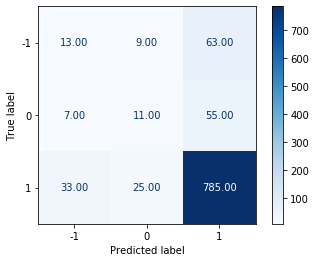

In [107]:
plot_confusion_matrix(clf, X_test, y_test, cmap = 'Blues', values_format= '.2f')

The Accuracy of Decsion Tree Classifier is <b>81%</b>

## Support Vector Machines

In [109]:
#Support vector machines
from sklearn.svm import SVC
svc = SVC(kernel = 'linear')
svc.fit(X_train,y_train)

y_pred3 = svc.predict(X_test)

In [112]:
# Accuracy
accuracy_score(y_test,y_pred3)

0.8111888111888111

In [110]:
print(classification_report(y_test,y_pred3))
print(confusion_matrix(y_test,y_pred3))

              precision    recall  f1-score   support

          -1       0.39      0.33      0.36        85
           0       0.15      0.12      0.14        73
           1       0.89      0.92      0.90       843

    accuracy                           0.81      1001
   macro avg       0.48      0.46      0.47      1001
weighted avg       0.79      0.81      0.80      1001

[[ 28  11  46]
 [ 15   9  49]
 [ 28  40 775]]


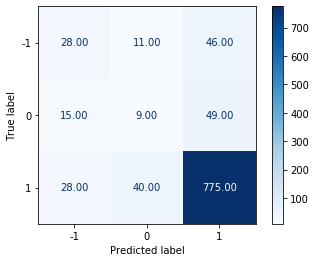

In [111]:
plot_confusion_matrix(svc, X_test, y_test, cmap = 'Blues', values_format= '.2f')

The Accuarcy of Support Vector Machines is <b>81%</b>

The classifier which is performing well on our data among the three is Naive Bayes Classifier with an Accuracy of 85%.

This Concludes our project of Sentiment Analysis with a note that the accuarcy of our models can be improved by creating a balanced dataset.